# Chi-squared test for independence: Exercise chat

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import math

## Loading and inspecting the data

In [2]:
chat = pd.read_csv("../../datasets/chat/chat.tsv", sep="\t")
chat

,nr_tokens,subject_ID,gender,education,emoticons,nonstd_Dutch
0,1487,1,male,general,49,292
1,1859,2,male,technical,49,298
2,178,3,male,general,0,32
3,258,4,female,general,0,53
4,48,5,male,vocational,0,3
...,...,...,...,...,...,...
1379,287,1380,female,technical,4,68
1380,407,1381,female,technical,25,66
1381,613,1382,female,general,1,96
1382,1657,1383,female,vocational,74,410


We create a new categorical variable, called "submission", indicating whether the participant's submission to the research project was "large" (>500 tokens of chat data) or "small" (<=500 tokens):

In [3]:
chat["submission"] = chat.nr_tokens.apply(lambda x: "large" if x > 500 else "small")
chat

,nr_tokens,subject_ID,gender,education,emoticons,nonstd_Dutch,submission
0,1487,1,male,general,49,292,large
1,1859,2,male,technical,49,298,large
2,178,3,male,general,0,32,small
3,258,4,female,general,0,53,small
4,48,5,male,vocational,0,3,small
...,...,...,...,...,...,...,...
1379,287,1380,female,technical,4,68,small
1380,407,1381,female,technical,25,66,small
1381,613,1382,female,general,1,96,large
1382,1657,1383,female,vocational,74,410,large


## Chi-squared test for independence

So much for what you already knew... Let us now proceed to a chi-squared test for independence. First, we formulate the hypotheses, i.e. a **null hypothesis $H_0$** and an **alternative hypothesis $H_1$**.

> ##### Question:
> What would your $H_0$ and $H_1$ be, based on the submissiontable (gender vs submission size)?

Before we perform a chi-squared test for independence, **we must test its assumptions**:
- are the data independent? (i.e., no repeated measurements)
- is the sample size sufficiently large or do we need a continuity correction?
- are the expected cell counts sufficiently large?

Let's start by testing the **first assumption: are there indeed no repeated measurements in the dataset?**

In [4]:
chat.subject_ID.is_unique

True

Okay, no repeated measurements! Each subject occurs exactly once in the dataset. In case we did encounter repeated measurements, we would not be allowed to perform a chi-squared test... Instead, we would have to use something else - we'll come back to that in the final session of this class.

Now, let's test the **second assumption: is the sample size sufficiently large?** A rule of thumb is that we want a sample size that is larger than 60 data points.

In [5]:
chat.shape[0] > 60

True

Okay, sample size is large enough! We will not need to 'tweak' our chi-squared test. If the sample size is too small, we would need a continuity correction (see below).

Finally, let's test the **third assumption: are the expected cells sufficiently large?**  All *expected* cell counts should be larger than or equal to 5. Note the emphasis on *expected*: it is a widely spread misconception that the *observed* cell counts need to be larger than 5... (Of course, if the observed cells are very small, the expected cells are more likely to be small too).

Once you have a result object from `sp.stats.chi2_contingency`, you can inspect the expected cell counts with `res.expected_freq`, or calculate them yourself, which we'll do below.

Note that for smaller counts, you can use other tests instead of a chi-squared test. For example a Fisher's Exact Test (`sp.stats.fisher_exact()`). If you have fewer than 1000 samples, it is often recommended to use Fisher, since there are fewer assumptions that need to be checked. The downside is that Fisher is a conservative test, so it may not have the statistical *power* to find a significant effect where one exists, and that **for Python there is no well-tested version of Fisher for tables bigger than 2x2**.

> NOTE There are two widely performed chi-square tests. The test for *independence* (what we are doing here) can usually be arranged as a "contingency table". For two variables with two categories, this is a 2x2 table. For this kind of test, it is *much easier* to use `scipy.stats.chi2_contingency()`.

> A related test when comparing two frequency histograms is the chi-square test for goodness-of-fit, found as `scipy.stats.chisquare()`. Although it is possible to use that test to get the same result, there is a confusing process called "adjusting the degrees of freedom". We might talk about the goodness-of-fit test another time. For now, just remember which is the right API.

As an argument, we give the **table** derived from our dataset (using `pd.crosstab`). The argument `correction` is set to false, since the sample size is large enough. If `correction` is true, a so-called **continuity correction** is applied: Gries (pp. 170-171 and 184-185) recommends to do so only when the sample size is small (*n* <= 60). When the sample size is larger, no additional correction is required. Some statisticians (me) recommend *always* using Yates correction when it applies, which is **only for 2x2 contingency tables**. The worst thing that will happen is that your $p$-value will be a little too conservative, but for large samples the correction will make almost no difference. The default for this option in scipy is `True`

In [6]:
obs = pd.crosstab(chat.gender, chat.submission)
obs

submission,large,small
gender,,
female,316,401
male,241,426


In [7]:
res = sp.stats.chi2_contingency(obs, correction=False)
res

Chi2ContingencyResult(statistic=9.059953337355319, pvalue=0.002612686455925458, dof=1, expected_freq=array([[288.56141618, 428.43858382],
       [268.43858382, 398.56141618]]))

Okay, looking at the `expected_freq` property of the result object, expected cell counts are large enough!

Since all three assumptions are met, the results of the test are valid. 

In [8]:
print(
    f"Chi2 Result: Statistic: {res.statistic.round(4)}, Degrees of Freedom: {res.dof}, p-value:{res.pvalue.round(4)}"
)

Chi2 Result: Statistic: 9.06, Degrees of Freedom: 1, p-value:0.0026


> ##### Question:
> How to interpret this result?

> NOTE: The $p$-value for $\chi^2$ tests is *very* dependent on the degrees of freedom parameter. Our $\chi^2$ statistic (about 9) is very unlikely given one degree of freedom, but if you increased the degrees just a little it would not be significant. Below we have plotted the CDF for $\chi^2$ for a few different degrees of freedom. Note how for 1 (the correct parameter here) almost all of the probability mass is to the left (so the result is unlikely), but the cumulative mass at the same x-value for 9 degrees is only around 0.6.

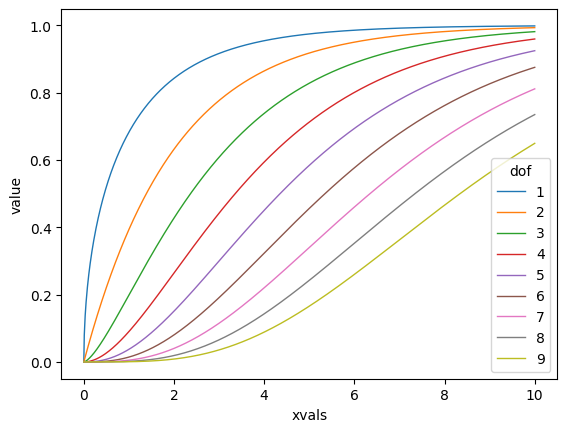

In [9]:
# You won't be expected to reproduce anything like this, but it doesn't actually use many tricks you
# haven't learned :)

cols = list("123456789")
X = np.linspace(0, 10, 1000)
yvals = [sp.stats.chi2.cdf(X, dof) for dof in range(1, 10)]
wide_df = pd.DataFrame(dict(zip(cols, yvals)))
wide_df["xvals"] = X
long_df = wide_df.melt(["xvals"], var_name="dof")
sns.lineplot(long_df, x="xvals", y="value", hue="dof", linewidth=1)
plt.show()

## Measures of effect size

Since the chi-square value and the p-value are dependent on sample size, it is very wise to provide a measure of effect size too.

Start by calculating odds ratio. First, calculate the **odds** for female and male participants of submitting a large donation. You find all necessary input for calculating these odds in your crosstab.

In [10]:
obs

submission,large,small
gender,,
female,316,401
male,241,426


In [11]:
# odds of "large submission" when gender = male:
# (male_large) / (male_small)
odds_male = 241 / 426
print(odds_male)

# odds of "large submission" when gender = female
# (female_large) / (female_small)
odds_female = 316 / 401
print(odds_female)

0.5657276995305164
0.7880299251870324


Now calculate the **odds ratio**, i.e. odds_female / odds_male. Note that you can also calculate it the other way around (odds_male/odds_female). You either get a score between 0 and 1, or between 1 and +inf. Both scores are equivalent (they are each other's inverse). The closer both scores are to 1, the smaller the effect size, and the further away they are from 1, the larger the effect size.

In [12]:
ratio = odds_female / odds_male
ratio

1.3929491623638002

In [13]:
inv_ratio = odds_male / odds_female
inv_ratio

0.7179012895941047

> ##### Question:
> How to interpret this ratio? Note that the version of the odds ratio expressed between 1 and +inf is usually the most intuitive one to interpret.

> NOTE: In more complex analysis, and especially where the odds are extremely small, or the samples are very large, or both, it is common to use **log-odds**. Dealing with odds as logarithms has a number of excellent mathematical advantages: the results are more *numerically stable*, and they can be multiplied (as normal odds) by *addition as logarithms*. They are, unfortunately, (even) more difficult to understand intuitively.

In addition, let's calculate another measure of effect size: **Cramer's V**. Cramer's V is a normalized version of the chi-squared value (normalized for sample size).
Here is the formula: 

> Cramer's V = $\Large \sqrt{\frac{\chi^2}{n * (min(nrow,ncols) -1)}}$

In which *n* is the sample size. To obtain the sample size, add margins to the crosstab `margins=True`. To obtain the number of rows and columns in your data table, either visually inspect the table, or use `shape` property *of the crosstab* (**not** the entire dataset!).

In [14]:
chat.shape[0]  # n samples

1384

In [15]:
obs.shape  # (nrow, ncols)

(2, 2)

> #### EXERCISE
> Now just fill in all the variables and convert the formula above from 'maths' to 'code'...

In [16]:
# code here

Luckily, scipy already has an API for a number of common measures of association, including Cramer's V, under `sp.stats.contingency.association`. You should look up the documentation :)

In [17]:
sp.stats.contingency.association(obs, method="cramer")

0.0809086463783862

> ##### Question:
> How to interpret this score?

## Chi-squared test (bis): recalculating by hand

**This part is optional**: for those of you interested in how Python calculates the chi-squared test and what's behind it (actually, it's all pretty intuitive!). Feel free to read through this part to get a better understanding of the test. However, **we do not expect you to perform these manual calculations at the exam**. What you *should* be able to do at the exam: inspect and visualize the data, perform a chi-squared test with `chi2_contingency()` (don't forget to test all three assumptions first!), correctly interpret the results, and finally provide the relevant measures of effect size.

Let's now go to the manual calculations.

Can you calculate the **expected frequencies** (based on $H_0$: no correlation between gender and submission size)? The formula to calculate the expected count for each cell is: 

> $\Large \frac{\sum_i{row_i} \times \sum_i{col_i}}{n}$

Get the row and column totals first with `margins=True`:

In [18]:
pd.crosstab(chat.gender, chat.submission, margins=True)

submission,large,small,All
gender,,,
female,316,401,717
male,241,426,667
All,557,827,1384


Now use these to calculate the expected frequencies. Compare your result to the expected frequencies calculated automatically by the `chi2_contingency()` method.

In [19]:
expected_female_large = (717 * 557) / 1384
expected_female_small = (717 * 827) / 1384
expected_male_large = (667 * 557) / 1384
expected_male_small = (667 * 827) / 1384

E = np.array(
    [
        [expected_female_large, expected_female_small],
        [expected_male_large, expected_male_small],
    ]
)
print(E)
print(sp.stats.chi2_contingency(obs, correction=False).expected_freq)

[[288.56141618 428.43858382]
 [268.43858382 398.56141618]]
[[288.56141618 428.43858382]
 [268.43858382 398.56141618]]


Can you calculate the **chi-squared value** by hand? Calculate the sum of the differences between observed and expected count per cell in the table:

> $\Large \chi^2 = \sum_{i=1}^{n}{\frac{(O_i - E_i)^2}{E_i}}$

Compare to the chi-squared value obtained by `chi2_contingency` (use the `.statistic` property of the result object). You should get the same result!

In [ ]:
O = obs.to_numpy()

sum = 0.0
# Enumerate the four indices for a 2d matrix, [0][0], [0][1], etc
for i in [0, 1]:
    for j in [0, 1]:
        # sum +=  <-- change the code here

print(f"By hand: {sum}, scipy: {res.statistic}, Equal: {sum==res.statistic}")

## Hand calculating $p$-values and critical values

> TIP: CHECK THE DOCS! ALWAYS CHECK THE DOCS!

Most of the continuous distributions in `sp.stats` have a very similar API, so learning one helps you to learn them all. In this case, the docs for the chi-square distribution are [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

Now check whether the chi-squared value you calculated is sufficiently large for the differences between observed and expected frequencies to be significant. 
You can check the **critical value** (i.e. the value that our chi-squared value needs to exceed for the correlation to be significant) in a chi-squared table with `sp.stats.chi2.isf()`. This is the 'inverse survival function', and it maps percentiles ((1 - CDF), which is often called the *survival function*) to statistic values.

Provide:
- the p-value (0.05 for humanities)
- degrees of freedom = **$(nrows-1) * (ncols-1)$**

Then compare the values: your previously obtained chi-squared value should be larger than the critical value for the correlation to be significant at p <= 0.05. It might also help to look at the CDF plot above for the line `dof=1` for an x-value of just under 4.

In [20]:
sp.stats.chi2.isf(0.05, 1)

3.8414588206941263

The chi-squared value is indeed larger than the critical value! So we know that expected and observed frequencies differ from each other significantly with p <= 0.05

Finally, obtain an **exact p-value** for the chi-squared test with `sp.stats.chi2.sf()`. This is the *survival function*, which we have seen before, and it maps statistics to $p$-values (more accurately, to 1 - CDF())

Provide:
- the obtained chi-squared value
- the degrees of freedom

Compare the obtained p-value to the p-value output by `chi2_contingency()`. They should be the same.

In [21]:
sp.stats.chi2.sf(res.statistic, 1)

0.002612686455925458

In [22]:
res.pvalue == sp.stats.chi2.sf(res.statistic, 1)

True

```
Version History

Current: v1.0.2

30/9/24: 1.0.0: first draft, BN
7/10/24: v 1.0.1: clarify some points on Fisher's test and Yates' correction, BN
08/10/24: v 1.0.2: typos + proofread, MK
```